<a href="https://colab.research.google.com/github/lijin-durairaj-code-mode/codes/blob/main/chromadb_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install chromadb
# !pip install langchain
# !pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chromadb 0.5.23 requires tokenizers<=0.20.3,>=0.13.2, but you have tokenizers 0.21.0 which is incompatible.


In [ ]:
import chromadb
from chromadb.config import Settings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import uuid
from datetime import datetime
from time import strftime

#configuration
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [ ]:
client=chromadb.Client()
employee=pd.ExcelFile('EmployeeMasterFile.xlsx')

In [ ]:
employee_list = pd.read_excel(pd.ExcelFile('EmployeeMasterFile.xlsx'), "Employee List")

In [ ]:
employee_list.head(1)

,Employee ID,Country,Name,First Name,Last Name,Hired Date,Date of Birth,Gender,Nationality,Department,Expertise,Competancy Role,Primary Industry,Secondary Industry,Industry Role,Regional Supervisor,Office Supervisor,Grade,Grade Description,Designation,Contracting Company,Location,Target Chargebility,Chargeout Rate,Professional Since,Home Address,Phone Number,Emergency Contact Name,Emergency Contact Number,Roles,Employee Sponsor,Termination Date,Rehired Date,Status
0,EA-HO-0001,HO,Sandeep Khapre,Sandeep,Khapre,1997-01-01,1967-06-04,Male,Mauritian,Advisory,NaN,Backstop,Government and Public Sector,NaN,Member,Sandeep Khapre,Sandeep Khapre,P5,RCEO,RCEO,BDO Africa Holdings Ltd,Nairobi,35,125.0,1989.0,NaN,NaN,NaN,NaN,Cluster View,N,NaT,NaN,A


## eda

In [ ]:
employee_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Employee ID               617 non-null    object        
 1   Country                   617 non-null    object        
 2   Name                      617 non-null    object        
 3   First Name                617 non-null    object        
 4   Last Name                 617 non-null    object        
 5   Hired Date                617 non-null    datetime64[ns]
 6   Date of Birth             617 non-null    datetime64[ns]
 7   Gender                    617 non-null    object        
 8   Nationality               612 non-null    object        
 9   Department                617 non-null    object        
 10  Expertise                 170 non-null    object        
 11  Competancy Role           366 non-null    object        
 12  Primary Industry      

<Axes: >

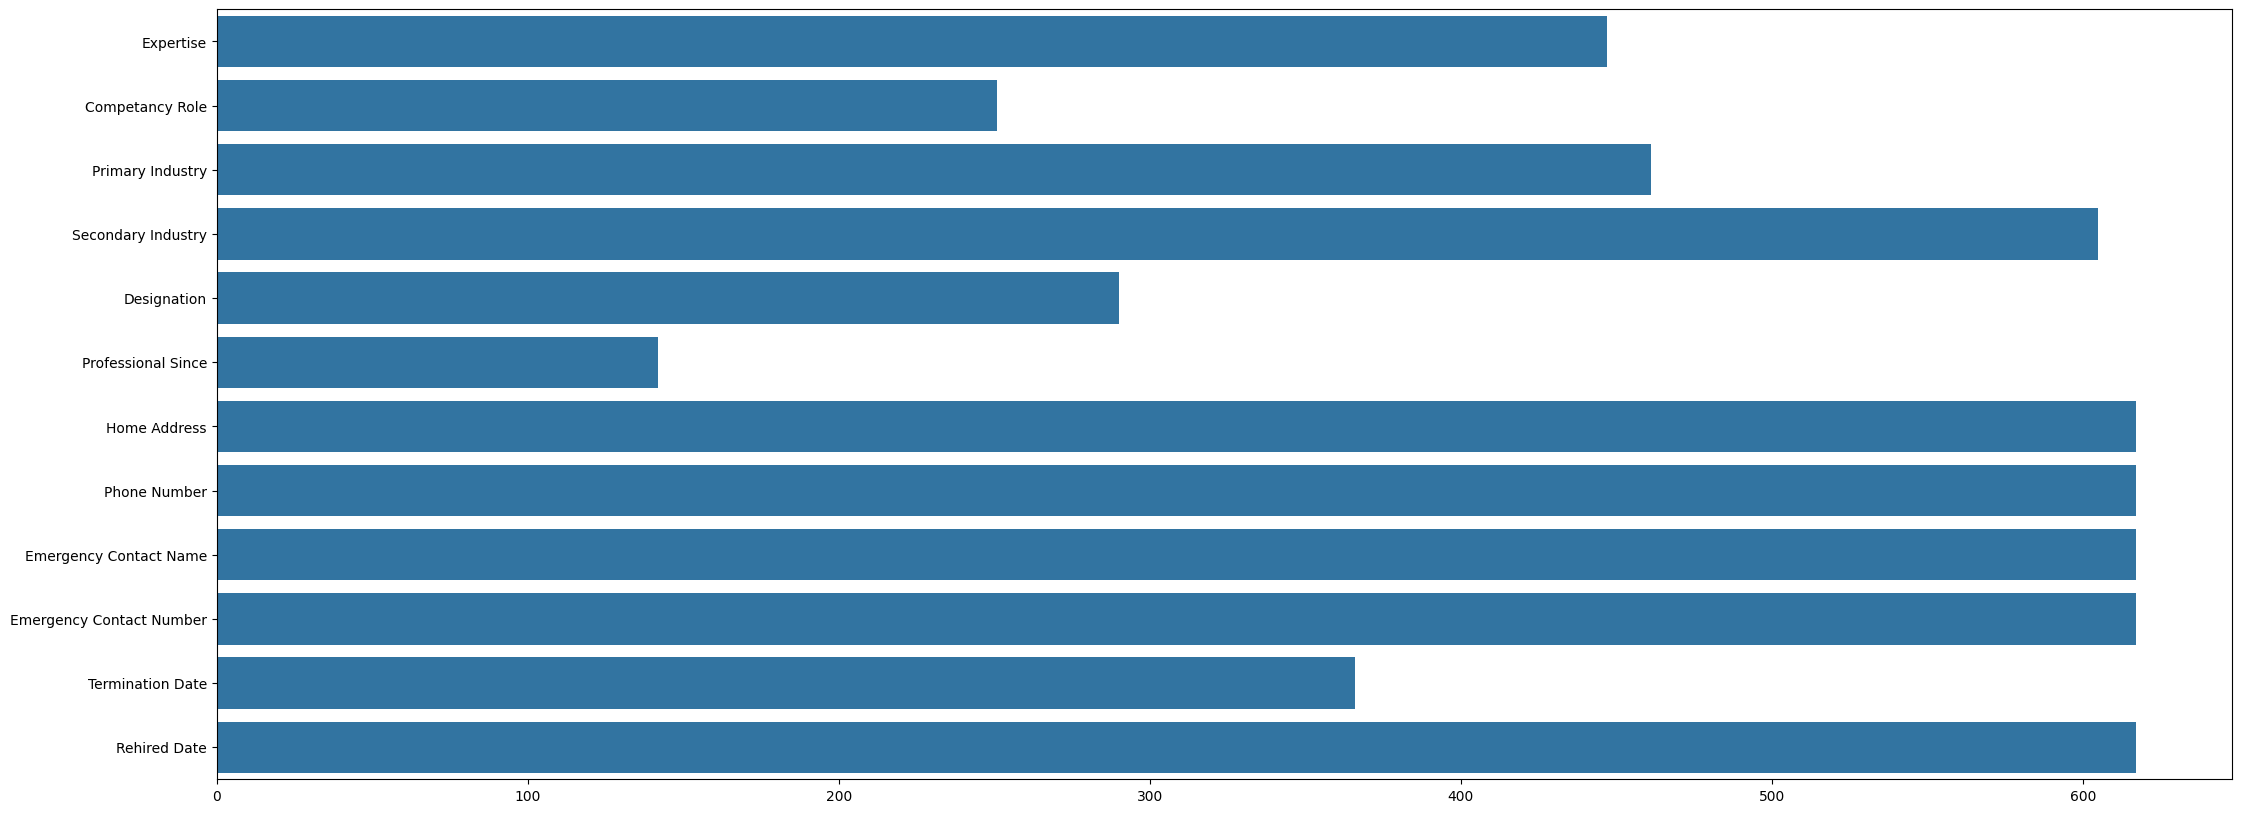

In [ ]:
# NAN > 15%
total_nan=employee_list.isna().sum()
plt.figure(figsize=(26,10))

many_NAN=total_nan[((total_nan/612)*100)>15]
sns.barplot(many_NAN,orient='h')

In [ ]:
col=[e for e in employee_list if e not in many_NAN.index]

In [ ]:
employee_list.loc[:,col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Employee ID          617 non-null    object        
 1   Country              617 non-null    object        
 2   Name                 617 non-null    object        
 3   First Name           617 non-null    object        
 4   Last Name            617 non-null    object        
 5   Hired Date           617 non-null    datetime64[ns]
 6   Date of Birth        617 non-null    datetime64[ns]
 7   Gender               617 non-null    object        
 8   Nationality          612 non-null    object        
 9   Department           617 non-null    object        
 10  Industry Role        617 non-null    object        
 11  Regional Supervisor  617 non-null    object        
 12  Office Supervisor    610 non-null    object        
 13  Grade                609 non-null  

<Axes: >

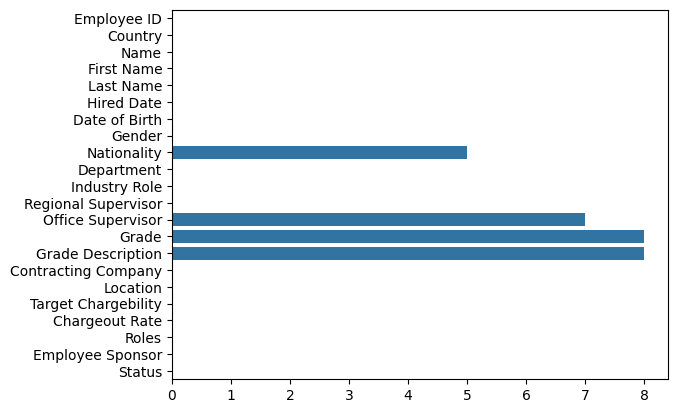

In [ ]:
sns.barplot(employee_list.loc[:,col].isna().sum(),orient='h')

## preparing data

In [ ]:
col=[e for e in employee_list if e not in many_NAN.index]
workable_dataset=employee_list.loc[:,col]

workable_dataset=workable_dataset.apply(lambda x:x.fillna(x.mode()[0]))

In [ ]:
workable_dataset.head(1)

,Employee ID,Country,Name,First Name,Last Name,Hired Date,Date of Birth,Gender,Nationality,Department,Industry Role,Regional Supervisor,Office Supervisor,Grade,Grade Description,Contracting Company,Location,Target Chargebility,Chargeout Rate,Roles,Employee Sponsor,Status
0,EA-HO-0001,HO,Sandeep Khapre,Sandeep,Khapre,1997-01-01,1967-06-04,Male,Mauritian,Advisory,Member,Sandeep Khapre,Sandeep Khapre,P5,RCEO,BDO Africa Holdings Ltd,Nairobi,35,125.0,Cluster View,N,A


In [ ]:
workable_dataset=(
    workable_dataset
.pipe(lambda x:x.assign(
    **{
        'Hired Date':x['Hired Date'].dt.strftime('%Y-%m-%d'),
        'Date of Birth':x['Date of Birth'].dt.strftime('%Y-%m-%d'),
    }
))
)

In [ ]:
def prepare_doc(row):
  contentObj=' '.join(map(str,row))
  metObj={}
  for c in row.index:
    metObj[c]=row[c]

  return {
      'content':contentObj,
      'meta':metObj,
      'id':str(uuid.uuid4())
  }

doc=workable_dataset.apply(lambda x:prepare_doc(x),axis=1)

## adding chroma DB

In [ ]:
collection=client.create_collection(name='employees')

In [ ]:
content_list=doc.apply(lambda x:x['content'])
meta_list=doc.apply(lambda x:x['meta'])
id_list=doc.apply(lambda x:x['id'])

In [ ]:
collection.add(
    documents=content_list.to_list(),
    metadatas=meta_list.to_list(),
    ids=id_list.to_list()
)

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:02<00:00, 30.0MiB/s]


In [ ]:
answer=collection.query(
    query_texts='EA-KE-0091',
    n_results=2
)

In [ ]:
answer

{'ids': [['ea570e0b-8855-469b-b496-f066f2683b2a',
   '9c48b75e-24e5-4231-8180-5bbd8700d031']],
 'embeddings': None,
 'documents': [['EA-KE-0220 Kenya Noordin Dualle Noordin Dualle 2024-01-04 1999-02-26 Male Kenyan Audit-C Member Justin Wambua John Gitahi A2 Assistant 2 BDO Kenya Limited Nairobi 90 25.0 Member View N A',
   'EA-KE-0232 Kenya Kelvin Ndaguri Kelvin Ndaguri 2024-03-20 1996-09-20 Male Kenyan Audit-B Member Justin Wambua Peris Macharia A2 Assistant 2 BDO Kenya Limited Nairobi 90 25.0 Member View N A']],
 'uris': None,
 'data': None,
 'metadatas': [[{'Chargeout Rate': 25.0,
    'Contracting Company': 'BDO Kenya Limited',
    'Country': 'Kenya',
    'Date of Birth': '1999-02-26',
    'Department': 'Audit-C',
    'Employee ID': 'EA-KE-0220',
    'Employee Sponsor': 'N',
    'First Name': 'Noordin',
    'Gender': 'Male',
    'Grade': 'A2',
    'Grade Description': 'Assistant 2',
    'Hired Date': '2024-01-04',
    'Industry Role': 'Member',
    'Last Name': 'Dualle',
    'Locati

In [ ]:
all_records=collection.get(include=["embeddings", "metadatas", "documents"])

## get QUERY embeddings manually

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
embedding_model=SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
query_text = "employee id EA-KE-0091"
norm_query_embedding=embedding_model.encode([query_text])

In [ ]:
norm_query_embedding

array([[-1.00101307e-01,  6.12305701e-02, -3.41379084e-02,
        -5.26857674e-02, -5.50944544e-03,  4.19523716e-02,
         1.23183437e-01, -4.90060933e-02,  5.68046561e-03,
        -6.58589900e-02,  1.34082595e-02, -4.91721705e-02,
        -6.28637969e-02, -7.04529360e-02, -7.44256005e-02,
        -3.63514423e-02, -3.25954184e-02,  1.88184064e-02,
         3.33815161e-03, -1.07610248e-01, -4.67929766e-02,
         6.47243205e-03, -6.45173565e-02, -4.69698235e-02,
        -2.67736595e-02, -1.58772804e-02,  8.93002525e-02,
         9.48461071e-02, -5.93543276e-02, -5.20518906e-02,
         9.18906108e-02, -3.63777168e-02,  2.60288026e-02,
        -2.59936508e-03,  1.05514392e-01, -1.45000257e-02,
        -2.20536254e-02,  6.83051646e-02,  2.32047811e-02,
         2.27552187e-03, -5.75323887e-02, -5.58808520e-02,
        -3.72764957e-03, -4.45832126e-02, -2.98794406e-03,
         3.22992988e-02, -7.87229910e-02,  8.22108891e-03,
        -8.66835937e-03,  7.81061873e-02,  7.67255276e-0

In [ ]:
embedding_query_result=collection.query(
    query_embeddings=norm_query_embedding.flatten(),
    n_results=2,
    include=['documents','distances','embeddings']
)

In [ ]:
embedding_query_result

{'ids': [['ea570e0b-8855-469b-b496-f066f2683b2a',
   '6e22dc97-66e3-47e7-ae85-533a9113b08c']],
 'embeddings': [array([[-8.14373195e-02,  8.17846879e-02,  1.55073474e-03,
          -5.18422248e-03, -6.00823723e-02,  7.41012618e-02,
           5.46181388e-02, -4.33029793e-02,  1.04170069e-02,
           8.06519017e-02,  4.87442799e-02, -1.11348882e-01,
          -3.89077105e-02, -3.43919881e-02, -1.12105176e-01,
          -3.85630270e-03, -1.80325843e-02,  4.32559215e-02,
          -5.54357581e-02,  2.25721784e-02, -1.45280370e-02,
          -4.24610777e-03, -1.29609497e-03, -6.93763122e-02,
           3.87938903e-03,  3.34557146e-03, -1.96433794e-02,
           5.83643429e-02, -2.56232861e-02, -1.11613728e-01,
          -1.60226598e-02, -3.14436629e-02,  3.41369174e-02,
           1.06378965e-01,  5.66479564e-02,  3.66079472e-02,
          -3.83574329e-02,  2.85253804e-02,  7.85633102e-02,
          -8.83558206e-03,  2.70926338e-02, -8.38963985e-02,
          -3.14862770e-03, -9.9993653

## re-selcting columns

In [ ]:
employeeid, country, name,
firstname, lastname, gender, nationality, department,
regional supervisor, office supervisor, designation, location,


In [ ]:
col=['Employee ID', 'Country', 'Name', 'First Name', 'Last Name','Date of Birth', 'Gender', 'Nationality', 'Department']
workable_dataset.loc[:,col].head(2)

,Employee ID,Country,Name,First Name,Last Name,Date of Birth,Gender,Nationality,Department
0,EA-HO-0001,HO,Sandeep Khapre,Sandeep,Khapre,1967-06-04,Male,Mauritian,Advisory
1,EA-TZ-0001,Tanzania,Sophia Chamzingo,Sophia,Chamzingo,1976-03-16,Female,Tanzanian,Finance


In [ ]:
doc=workable_dataset.loc[:,col].apply(lambda x:prepare_doc(x),axis=1)
content_list=doc.apply(lambda x:x['content'])
meta_list=doc.apply(lambda x:x['meta'])
id_list=doc.apply(lambda x:x['id'])

In [ ]:
doc[0]

{'content': 'EA-HO-0001 HO Sandeep Khapre Sandeep Khapre 1967-06-04 Male Mauritian Advisory',
 'meta': {'Employee ID': 'EA-HO-0001',
  'Country': 'HO',
  'Name': 'Sandeep Khapre',
  'First Name': 'Sandeep',
  'Last Name': 'Khapre',
  'Date of Birth': '1967-06-04',
  'Gender': 'Male',
  'Nationality': 'Mauritian',
  'Department': 'Advisory'},
 'id': '8d0e9347-de80-489f-af26-662a848978d6'}

In [ ]:

new_collection=client.create_collection(name='employees_revamp')
new_collection.add(
    documents=content_list.to_list(),
    metadatas=meta_list.to_list(),
    ids=id_list.to_list()
)

In [ ]:
result=new_collection.query(
    query_texts='can you please do me a favour and get the employee by the name Samson, he was a very nice guy but he was driving while while still on the phone',
    n_results=10,
    include=['documents','embeddings']
)

In [ ]:
result

{'ids': [['2b9983e6-1b47-4fa8-9eea-9e4d735ed2a9',
   '2f6dea7a-f94a-4547-aab7-3efbc27ebb53',
   '86e5d970-fec0-4f2a-9be5-3461603a8652',
   '4d14d9b4-af2c-4948-8b79-17e643ec2bfb',
   'f3267907-cf42-46e6-990f-38060fce5931',
   'c0271705-33ee-4486-9712-324288a10f70',
   '94f127bf-664f-4afc-b917-df6b93619cff',
   '19110407-f7ae-431c-9b9f-a30cdddb7dfe',
   'e484629f-579e-4702-a669-50ce43379e4b',
   '745f6562-24c0-4d0d-86f1-e5a9019d551c']],
 'embeddings': [array([[-0.14230411,  0.12986077, -0.0043958 , ..., -0.07038055,
          -0.0402827 , -0.02167685],
         [-0.09448653,  0.15135951, -0.02811167, ..., -0.05230637,
          -0.01386429,  0.00888693],
         [-0.11790305,  0.10211559, -0.04598312, ..., -0.08218052,
          -0.04091911, -0.00754032],
         ...,
         [-0.10818885,  0.1157889 , -0.01110078, ..., -0.06045576,
          -0.03902635, -0.03215328],
         [-0.09638215,  0.13305765, -0.05816536, ..., -0.07894876,
          -0.01226308,  0.01581867],
         [-0.